# Tutorial on self-normalizing networks on the MNIST data set: convolutional neural networks

*Author:* Kajetan Schweighofer, 2021

In [64]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
# load data and preprocess

path = os.path.join(".", "dataset", "mnist")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor and normalize
transform = transform=transforms.Compose([
    transforms.ToTensor(),
])

train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

In [66]:
class CNN(nn.Module):

    def __init__(self, out_features: int, p_drop=0.2, use_selu: bool=False):
        super(CNN, self).__init__()

        # SELU and AlphaDropout are already included in Pytorch Releases > 1.7.1
        activation = nn.SELU() if use_selu else nn.ReLU()
        dropout = nn.AlphaDropout(p=p_drop) if use_selu else nn.Dropout(p=p_drop)

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            activation,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            activation,
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=out_features)
        )

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [67]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [68]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:
        x = x.to(next(network.parameters()).device)

        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [69]:
epochs = 20
lr = 1e-2
batch_size = 128
num_workers = 4
p_drop = 0.05

### Create Dataloaders

In [70]:
# obtain validation set (1/6 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [71]:
# ReLU training

# 28x28 = 784 input images for 10 classes
network = CNN(out_features=10, p_drop=p_drop, use_selu=False).to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 20: 100%|██████████| 20/20 [02:49<00:00,  8.47s/it]


train loss: 2.1629, val loss: 1.4537, accuracy: 69.52%
train loss: 0.6434, val loss: 0.4040, accuracy: 88.14%
train loss: 0.3676, val loss: 0.3129, accuracy: 90.64%
train loss: 0.2938, val loss: 0.2551, accuracy: 92.28%
train loss: 0.2417, val loss: 0.2525, accuracy: 92.01%
train loss: 0.2041, val loss: 0.1844, accuracy: 94.53%
train loss: 0.1755, val loss: 0.1565, accuracy: 95.45%
train loss: 0.1530, val loss: 0.1411, accuracy: 95.77%
train loss: 0.1363, val loss: 0.1268, accuracy: 96.29%
train loss: 0.1229, val loss: 0.1197, accuracy: 96.49%
train loss: 0.1129, val loss: 0.1152, accuracy: 96.54%
train loss: 0.1044, val loss: 0.1077, accuracy: 96.88%
train loss: 0.0979, val loss: 0.1007, accuracy: 96.97%
train loss: 0.0914, val loss: 0.0923, accuracy: 97.21%
train loss: 0.0864, val loss: 0.0921, accuracy: 97.05%
train loss: 0.0812, val loss: 0.0886, accuracy: 97.43%
train loss: 0.0774, val loss: 0.0875, accuracy: 97.37%
train loss: 0.0744, val loss: 0.0809, accuracy: 97.44%
train loss

In [72]:
# SELU training
network = CNN(out_features=10, p_drop=p_drop, use_selu=True).to(device)
stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 20: 100%|██████████| 20/20 [02:36<00:00,  7.81s/it]


train loss: 1.2665, val loss: 0.4315, accuracy: 87.88%
train loss: 0.3699, val loss: 0.2902, accuracy: 91.63%
train loss: 0.2715, val loss: 0.2317, accuracy: 93.17%
train loss: 0.2199, val loss: 0.1934, accuracy: 94.16%
train loss: 0.1866, val loss: 0.1701, accuracy: 94.85%
train loss: 0.1627, val loss: 0.1492, accuracy: 95.49%
train loss: 0.1446, val loss: 0.1338, accuracy: 95.95%
train loss: 0.1289, val loss: 0.1230, accuracy: 96.13%
train loss: 0.1193, val loss: 0.1141, accuracy: 96.49%
train loss: 0.1096, val loss: 0.1080, accuracy: 96.54%
train loss: 0.1031, val loss: 0.0992, accuracy: 96.93%
train loss: 0.0968, val loss: 0.0940, accuracy: 97.03%
train loss: 0.0906, val loss: 0.0894, accuracy: 97.23%
train loss: 0.0859, val loss: 0.0851, accuracy: 97.31%
train loss: 0.0818, val loss: 0.0834, accuracy: 97.37%
train loss: 0.0780, val loss: 0.0791, accuracy: 97.45%
train loss: 0.0748, val loss: 0.0774, accuracy: 97.56%
train loss: 0.0719, val loss: 0.0739, accuracy: 97.68%
train loss

### Plot results

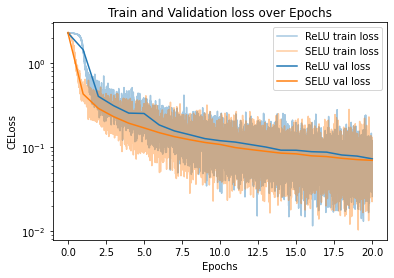

In [73]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

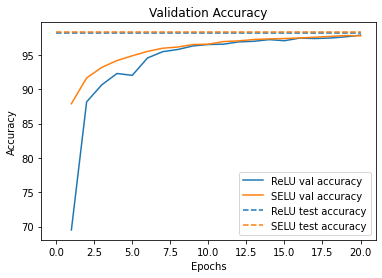

In [74]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()